## 类别预测层<br>
如果用全连接层来预测锚框所属类别，参数过多，所以采用卷积层的通道来输出类别预测<br>
kernel_size=3, padding=1, 卷积层保持输入的宽度和高度不变，这样输入和输出在特征图宽和高上的空间坐标一一对应<br>
目标类别数量q，锚框有q+1个类别，0类是背景。以每个单元为中心生成a个锚框<br>
输出特征图上坐标(x, y)的通道里包含了以输入特征图上坐标(x, y)为中心生成的所有锚框的类别预测, 输出通道数a(q+1)<br>

In [1]:
%matplotlib inline
import torch 
import torchvision
from torch import nn 
from torch.nn import functional as F 
from d2l import torch as d2l 

def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1), kernel_size=3, padding=1)

## 边界框预测层<br>
设计与类别预测层类似，不同的是，这里需要为每个锚框预测4个偏移量

In [2]:
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)

## 连接多尺度的预测<br>
单发多框检测使用多尺度特征图来生成锚框并预测其类别和偏移量，不同尺度下，由于特征图形状不一样或以同一单元为中心的锚框数不一样，预测输出的形状也可能不同<br>
需要连接多尺度进行预测<br>

In [ ]:
def forward(x, block):
    return block(x)

Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))  # 为同一小批量构建两个不同比例的特征图
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
# 通道数 = 锚框数 * (目标类别+1) ，如55 = 5 * (10+1)
Y1.shape, Y2.shape   # (批量大小，通道数，高度，宽度)

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

In [ ]:
# 小批量的批量大小相同，将高度、宽度、通道数相乘，以便连接
def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

In [6]:
concat_preds([Y1, Y2]).shape

torch.Size([2, 25300])

## 高和宽减半块

In [8]:
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

In [9]:
forward(torch.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

## 基础网络块<br>
用于从输入图像中抽取特征，网络串联3个高和宽减半块，并逐步将通道数翻倍

In [11]:
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)

forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

## 完整的模型

In [12]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1, 1))
    else:
        blk = down_sample_blk(128, 128)
    return blk 

In [13]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio)   # 生成锚框
    cls_preds = cls_predictor(Y)                                # 锚框预测的类别
    bbox_preds = bbox_predictor(Y)                              # 锚框预测的偏移量
    return (Y, anchors, cls_preds, bbox_preds)

In [14]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79], [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5 
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [15]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            # 即赋值语句self.blk_i=get_blk(i)
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i], num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i], num_anchors))
    
    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5 
        for i in range(5):
            # getattr(self, 'blk_%d'%i)即访问self.blk_i
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(X, getattr(self, f'blk_{i}'), sizes[i], ratios[i], 
                                                                     getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds 

In [16]:
net = TinySSD(num_classes=1)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


d:\anaconda\envs\d2l\lib\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


训练模型

## 读取数据集和初始化

In [17]:
batch_size = 32
train_iter, _ = d2l.load_data_bananas(batch_size)

read 1000 training examples
read 100 validation examples


In [18]:
def try_xpu(i=0):
    """如果存在,则返回gpu(i),否则返回cpu()"""
    if torch.xpu.device_count() >= i+1:
        return torch.device(f'xpu:{i}')
    return torch.device('cpu')

In [19]:
device, net = try_xpu(), TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

## 定义损失函数和评价函数

In [23]:
# SSD将锚框的偏移量作为学习目标

# 损失函数
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    # bbox_masks掩码变量，令负类锚框和填充锚框不参与损失的计算
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes), cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks, bbox_labels * bbox_masks).mean(dim=1)
    # 锚框类别损失 + 锚框偏移量损失
    return cls + bbox

In [21]:
# 评价函数
def cls_eval(cls_preds, cls_labels):
    # 由于类别预测结果放在最后一维，argmax需要指定最后一维
    return float((cls_preds.argmax(dim=-1).type(cls_labels.dtype) == cls_labels).sum())  # 准确数

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    # 绝对误差总和
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

## 训练模型

class err 3.26e-03, bbox mae 3.13e-03
2597.8 examples/sec on xpu:0


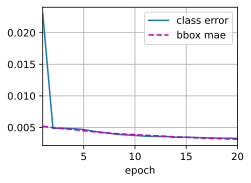

In [24]:
num_epochs, timer = 20, d2l.Timer()
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=['class error', 'bbox mae'])

net = net.to(device)
for epoch in range(num_epochs):
    # 训练精度的和，训练精度的和中的示例数
    # 绝对误差的和，绝对误差的和中的示例数
    metric = d2l.Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        # 生成多尺度锚框，为每个锚框预测类别和偏移量
        anchors, cls_preds, bbox_preds = net(X)
        # 为每个锚框标注类别和偏移量
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)
        # 根据类别和偏移量的预测
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks)
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(), 
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks), bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch+1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on {str(device)}')

## 预测目标

In [25]:
X = torchvision.io.read_image('../img/banana.jpg').unsqueeze(0).float()
img = X.squeeze(0).permute(1, 2, 0).long()

In [29]:
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = d2l.multibox_detection(cls_probs, bbox_preds, anchors)  # 移除相似的预测边界框
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]
output = predict(X)

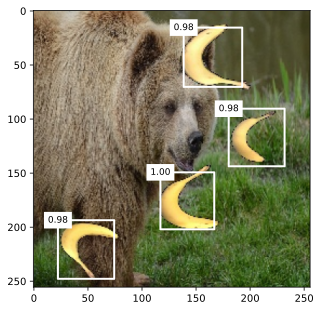

In [31]:
# 筛选出所有置信度不低于0.9的边界框作为最终输出
def display(img, output, threshold):
    d2l.set_figsize((5, 5))
    fig = d2l.plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')
display(img, output.cpu(), threshold=0.9)

练习

通过改进损失函数来改进SSD模型<br>
$$
f(x)=\begin{cases}({\sigma}x)^2/2,\,\,|x|<1/{\sigma}^2\\
                    |x|-0.5/{\sigma}^2,\,\,其他\\
     \end{cases}        
$$
当$\sigma$非常大时，这种损失类似于$L_1$范数损失;当较小时，损失函数较平滑<br>
注：'\,'是latex里的间距控制符号，表示插入一个较小的空格(约为\thinspace)

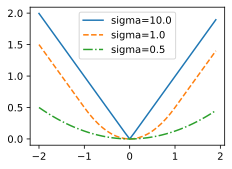

In [32]:
def smooth_l1(data, scalar):
    out = []
    for i in data:
        if abs(i) < 1 / (scalar ** 2):
            out.append(((scalar * i) ** 2) / 2)
        else:
            out.append(abs(i) - 0.5 / (scalar ** 2))
    return torch.tensor(out)

sigmas = [10, 1, 0.5]
lines = ['-', '--', '-.']
x = torch.arange(-2, 2, 0.1)
d2l.set_figsize()

for l, s in zip(lines, sigmas):
    y = smooth_l1(x, scalar=s)
    d2l.plt.plot(x, y, l, label='sigma=%.1f' % s)
d2l.plt.legend();

使用焦点损失<br>
给定超参数$\gamma>0$和$\alpha>0$, 损失为$-\alpha(1-p_j)^{\gamma}log\,p_j$<br>
增大$\gamma$可以有效减少正类预测概率较大时的相对损失，将训练更集中到那些错误分类的困难示例上

In [33]:
def focal_loss(gamma, x):
    return -(1-x) ** gamma * torch.log(x)

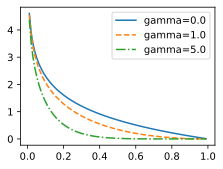

In [34]:
x = torch.arange(0.01, 1, 0.01)

for l, gamma in zip(lines, [0, 1, 5]):
    y = d2l.plt.plot(x, focal_loss(gamma, x), l, label='gamma=%.1f' % gamma)
d2l.plt.legend();